In [12]:
import numpy as np
import sys
import csv
import re
import scipy.sparse as sp
import datetime
# method = sys.argv[1]
# learning_rate = int(sys.argv[2])
# iterations = int(sys.argv[3])
# batch_size = int(sys.argv[4])
# training_data_path = sys.argv[5]
# vocabulary_path = sys.argv[6]
# testing_data_path = sys.argv[7]
# output_path = sys.argv[8]

lambdas = [0.1,1,10,100,1000]
folds = 10

method = 3
learning_rate = 0.001
iterations = 100
batch_size = 128
training_data_path = '../data/imdb_train.csv'
vocabulary_path = '../data/imdb_vocab'
testing_data_path = '../data/imdb_test.csv'
output_path = 'out/imdb_output_a.txt'

logLike = []

In [32]:
def load(data_path,vocab_map,num_features):
    Y = []
    S = []
#     regex = re.compile('[^a-zA-Z ]')
    with open(data_path, 'r') as csvfile:
#         print('Opened File ',datetime.datetime.now())
        spamreader = csv.reader(csvfile, delimiter=',')
        spamreader = list(spamreader)
        n = len(spamreader)
        S = sp.dok_matrix((n,num_features), dtype=np.int64)
        #X = np.zeros((n,num_features))
        Y = np.zeros((n,1))
        i = 0
#         print('Starting Read ',datetime.datetime.now())
        for row in spamreader:
#             cleaned_text = regex.sub('',row[1])
#             print('Splitting Row  ',i,datetime.datetime.now())
            prevTime = datetime.datetime.now()
            words = row[1].split(' ')
#             print('Splitting Row  ',i,' in ',datetime.datetime.now()-prevTime)
            S[i,0] = 1
            prevTime = datetime.datetime.now()
            
#             print('Starting Word Updation ',datetime.datetime.now())
            for word in words:
                if word in vocab_map:
                    S[i,vocab_map[word]] += 1
#                 try:
#                     S[i,vocab_map[word]] += 1
                    
#                 except:
#                     continue
#             print('Ending Word Updation ',datetime.datetime.now())
#             print('Word Updation in',datetime.datetime.now() - prevTime)
            Y[i] = int(row[0])
            i += 1
#     print('Returing From load  ',datetime.datetime.now())
    return S.tocsr(),Y

def load_data(data_path,vocab_map,num_features):
#     print('Load Data in ',datetime.datetime.now())
    X_sparse,Y = load(data_path,vocab_map,num_features)
#     print('Load Data Out ',datetime.datetime.now())
    return X_sparse,Y

def load_vocab(data_path):
    vocab_map = {}
    with open(data_path, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')        
        i = 0
        for row in spamreader:
            if row[0] not in vocab_map:
                vocab_map[row[0]] = i + 1
                i += 1
    return vocab_map, i+1

def sigmoid(t):
    return 1.0 / (1.0 + np.exp(t * -1))

def get_log_likelihood(W,X,Y):
    X_W = X.dot(W)
    Predictions = sigmoid(X_W)
    return np.sum(Y.T.dot(np.log(Predictions)) + (1-Y.T).dot(np.log(1-Predictions)))/Y.shape[0]

def get_predictions(W,X,threshold=0.5):
    X_W = X.dot(W)
#     return np.rint(sigmoid(X_W))
    return (sigmoid(X_W) > threshold).astype(np.int)

def get_accuracy(W,X,Y,threshold=0.5):
    Predictions = get_predictions(W,X,threshold)
    return 100*np.sum(Predictions == Y)/Y.shape[0]

def f_dash_gamma(X_W,Xd,Y,gamma):
    return (sigmoid(X_W + Xd.dot(gamma)) - Y).T.dot(Xd)

def get_optimal_learning_rate(W,X,Y):
    X_W = X.dot(W)
    d = X.T.dot(Y - sigmoid(X_W))
    d = d / np.linalg.norm(d)
    Xd = X.dot(d)
    
    gamma1 = 0.0
    gamma2 = 1.0
#     print(np.absolute(gamma1-gamma2) > 0.001)
    while(np.absolute(gamma1-gamma2) > 0.001):
        mid = (gamma1 + gamma2)/2
        f_dash_val = f_dash_gamma(X_W,Xd,Y,mid)
#         print(gamma1,gamma2,f_dash_val)
        if (f_dash_val < 0):
            gamma1 = mid
        else:
            gamma2 = mid
    
    return (gamma1 + gamma2) / 2

def train_model(X,Y,iterations,learning_rate,lam,learning_rate_mode = 0):
    m = X.shape[1]
    n= X.shape[0]
    W = np.zeros((m,1))
    XT = X.transpose()
    for i in range(iterations):
        g_val = sigmoid(X.dot(W))
#         print('Accuracy = ',get_accuracy(W,X,Y))
        logLike.append(get_log_likelihood(W,X,Y))
#         print('Log Likeli = ',get_log_likelihood(W,X,Y))
        if (learning_rate_mode == 1):
            W = W + (XT.dot(Y-g_val) - W.dot(lam)).dot(learning_rate).dot(1/n)
        elif (learning_rate_mode == 2):
            W = W + (XT.dot(Y-g_val) - W.dot(lam)).dot(learning_rate / np.sqrt(i+1)).dot(1/n)
        else:
            lr = get_optimal_learning_rate(W,X,Y)
#             print('Best Learning Rate ..= ',lr)
            W = W + (XT.dot(Y-g_val) - W.dot(lam)).dot(lr).dot(1/n)
    return W

def kFold_cross_validation(X,Y,lambdas,folds,iterations,learning_rate,learning_rate_mode):
    
    fold_size = int(X.shape[0]/folds)
    
    sums = []
    for lam in lambdas:
        sums.append(0.0)
        
    for i in range(folds):
        if i < folds - 1 :
            X_test = X[i*fold_size:(i+1)*fold_size]
            X_train = sp.vstack((X[:i*fold_size],X[(i+1)*fold_size:]))
            Y_test = Y[i*fold_size:(i+1)*fold_size]
            Y_train = np.vstack((Y[:i*fold_size],Y[(i+1)*fold_size:]))
        else:
            X_test = X[i*fold_size:]
            X_train = X[:i*fold_size]
            Y_test = Y[i*fold_size:]
            Y_train = Y[:i*fold_size]
        for i in range(len(lambdas)):
            W= train_model(X_train,Y_train,iterations,learning_rate,lambdas[i],learning_rate_mode)
#             sums[i] += get_log_likelihood(W,X_test,Y_test)
            sums[i] += get_accuracy(W,X_test,Y_test)
        print(sums)
    for i in range(0,len(sums)):
        sums[i] /= folds
    return sums

In [3]:
vocab_map, m = load_vocab(vocabulary_path)

In [4]:
# print(vocab_map)
# print(m)

In [5]:
X,Y = load_data(training_data_path,vocab_map,m)

In [38]:
#print(X_train_sparse)
#print(Y_train)

In [39]:
# print(X.shape)

In [40]:
# print(Y.shape)

In [41]:
logLike = []
W = train_model(X,Y,iterations,learning_rate,0.01,1)
print(logLike)

[-0.6931471805599451, -0.6927995588067439, -0.6924791810744882, -0.6921789215507754, -0.6918935902961312, -0.6916194077457437, -0.691353621258889, -0.6910942256824975, -0.6908397598766137, -0.6905891586196449, -0.6903416448447004, -0.6900966512290374, -0.689853763139701, -0.6896126771150467, -0.6893731706480292, -0.6891350801917325, -0.6888982851474829, -0.6886626962065928, -0.6884282468608348, -0.6881948872195914, -0.6879625795064193, -0.6877312947785089, -0.6875010105367437, -0.6872717089844278, -0.6870433757585357, -0.6868159990051909, -0.6865895687059461, -0.6863640761868006, -0.6861395137603767, -0.6859158744651295, -0.6856931518752719, -0.6854713399622347, -0.685250432993687, -0.6850304254599292, -0.6848113120202387, -0.6845930874637564, -0.6843757466809718, -0.6841592846429313, -0.6839436963860763, -0.6837289770011857, -0.683515121625304, -0.6833021254358514, -0.683089983646319, -0.6828786915031206, -0.6826682442832863, -0.6824586372927683, -0.682249865865195, -0.682041925360946

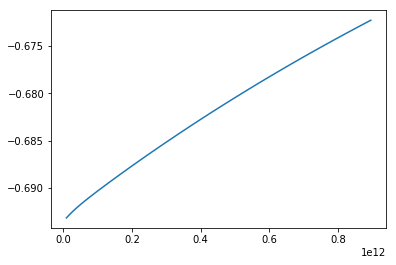

In [42]:
import matplotlib.pyplot as plt
import numpy as np

x_values = []
for i in range(len(logLike)):
    x_values.append((i+1)*8953258112)

plt.plot(x_values,logLike)
plt.show()

In [43]:
logLike = []
W = train_model(X,Y,iterations,learning_rate,0.01,2)
print(logLike)

[-0.6931471805599451, -0.6927995588067439, -0.6925718133292454, -0.6923940850926811, -0.6922450382924086, -0.6921149795611898, -0.6919985860206432, -0.6918925825604386, -0.6917947937415686, -0.6917036924719618, -0.6916181609433735, -0.6915373535906459, -0.6914606135910959, -0.6913874194497391, -0.6913173494442867, -0.6912500571610772, -0.6911852541833822, -0.6911226975425282, -0.6910621804294628, -0.6910035251926008, -0.6909465779730983, -0.6908912045350036, -0.6908372869820263, -0.6907847211421401, -0.6907334144620755, -0.6906832842959351, -0.6906342565018774, -0.6905862642820959, -0.6905392472167537, -0.6904931504538995, -0.6904479240258323, -0.6904035222687531, -0.6903599033273633, -0.6903170287297861, -0.6902748630210647, -0.6902333734457186, -0.690192529671621, -0.6901523035488453, -0.6901126688982503, -0.6900736013254722, -0.6900350780567085, -0.6899970777932732, -0.6899595805823832, -0.6899225677020274, -0.6898860215580985, -0.6898499255922399, -0.6898142641990783, -0.6897790226

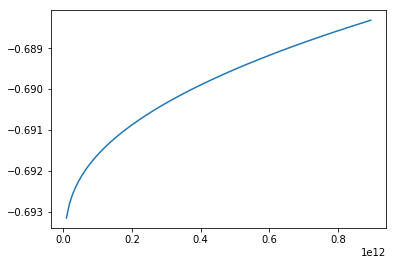

In [44]:
x_values = []
for i in range(len(logLike)):
    x_values.append((i+1)*8953258113)

plt.plot(x_values,logLike)
plt.show()

In [45]:
logLike = []
W = train_model(X,Y,iterations,learning_rate,0.01,3)
print(logLike)

[-0.6931471805599451, -0.6898277316608477, -0.6865485022592239, -0.6837142593214708, -0.6806297555870999, -0.6780920780266465, -0.6753174200181526, -0.6730373811822479, -0.6705252680033841, -0.6684701817936799, -0.6660739772738432, -0.6643074488635224, -0.6615857357468837, -0.6602204772429859, -0.6498621312784094, -0.6478807080505633, -0.6448218071902285, -0.6439297520233177, -0.6382689075541528, -0.6372668285598181, -0.6362882502490115, -0.6348673387673197, -0.6341435389509575, -0.6282175441146657, -0.6273361898259976, -0.6266854230163516, -0.6231286774819952, -0.6226127589253958, -0.6221027485877934, -0.5948530841775119, -0.5939171915531515, -0.5936690764873658, -0.5932853697633697, -0.5866043373305686, -0.5860811030624912, -0.5858480217399117, -0.5855262420314531, -0.5596739220530125, -0.5587233562530174, -0.5585452973574552, -0.5583995325938901, -0.5581539373868326, -0.5490178751967324, -0.5485184365456717, -0.548355427415648, -0.5482229361034252, -0.5480429104265258, -0.5405794064

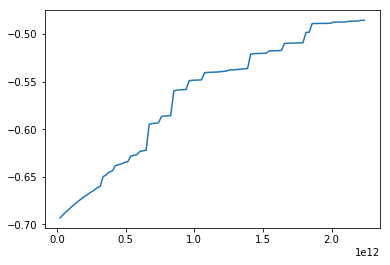

In [46]:
x_values = []
for i in range(len(logLike)):
    x_values.append((i+1)*22384962178)

plt.plot(x_values,logLike)
plt.show()

In [14]:
# W = train_model(X,Y,iterations,learning_rate,0.01)

# W = train_model(X,Y,iterations,learning_rate,0.01,1)
accuracy = kFold_cross_validation(X,Y,lambdas,folds,iterations,learning_rate,method)

In [15]:
max = accuracy[0]
lam = lambdas[0]

for i in range (0,len(lambdas)):
    if (accuracy[i] > max):
        lam = lambdas[i]
        max = accuracy[i]
        
print(lam)

0.1


In [43]:
W = train_model(X,Y,iterations,learning_rate,lam,method)

In [9]:
X_test,Y_test = load_data(testing_data_path,vocab_map,m)

In [44]:
print(get_accuracy(W,X_test,Y_test,0.5))
print(get_predictions(W,X_test,0.45))
print(sigmoid(X_test.dot(W)))

79.644
[[0]
 [1]
 [1]
 ...
 [0]
 [1]
 [1]]
[[0.38352438]
 [0.86218907]
 [0.74758205]
 ...
 [0.1783932 ]
 [0.62908738]
 [0.47036582]]


In [ ]:
# print(X_test.shape)

In [9]:
Predictions = get_predictions(W,X_test)
np.savetxt(output_path,Predictions,fmt="%i")